# Graph Construction

Let's look at how to build a graph from a raw text.

This work is based on 
["TextRank: Bringing Order into Text"](http://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf),
Rada Mihalcea, Paul Tarau, _Empirical Methods in Natural Language Processing_ (2004).

---
First we perform some basic housekeeping for Jupyter and then load `spaCy` ...

In [1]:
import logging
import sys
import warnings

warnings.filterwarnings("ignore")
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger("PyTR")

In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")

INFO:transformers.file_utils:PyTorch version 1.3.0 available.
INFO:transformers.modeling_xlnet:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


Now, to get started, we'll create some text to use.

In [3]:
#text = "When Ada was twelve years old, this future 'Lady Fairy', as Charles Babbage affectionately called her, decided she wanted to fly. Ada Byron went about the project methodically, thoughtfully, with imagination and passion. Her first step, in February 1828, was to construct wings. She investigated different material and sizes. She considered various materials for the wings: paper, oilsilk, wires, and feathers. She examined the anatomy of birds to determine the right proportion between the wings and the body. She decided to write a book, Flyology, illustrating, with plates, some of her findings. She decided what equipment she would need; for example, a compass, to 'cut across the country by the most direct road', so that she could surmount mountains, rivers, and valleys. Her final step was to integrate steam with the 'art of flying."

text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types."

doc = nlp(text)

How many sentences are in the parsed document and where are their boundaries?

In [4]:
for sent in doc.sents:
    print(">", sent.start, sent.end)

> 0 13
> 13 33
> 33 61
> 61 91


What are the raw _noun chunks_ in the parsed document, as well as its _named entities_?

In [5]:
for chunk in doc.noun_chunks:
    print(chunk.text)

Compatibility
systems
linear constraints
the set
natural numbers
Criteria
compatibility
a system
linear Diophantine equations
strict inequations
nonstrict inequations
Upper bounds
components
a minimal set
solutions
algorithms
construction
minimal generating sets
solutions
all types
systems
These criteria
the corresponding algorithms
a minimal supporting set
solutions
all the considered types systems
systems
mixed types


In [6]:
for ent in doc.ents:
    print(ent.text, ent.label_, ent.start, ent.end)

Diophantine ORG 21 22


Given those details about the parsed document, next we use [NetworkX](https://networkx.github.io/) to manage an in-memory graph...

In [7]:
import networkx as nx

def increment_edge (graph, node0, node1):
    if logger:
        logger.debug("link {} {}".format(node0, node1))
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

Then construct a graph, sentence by sentence, based on the [spaCy part-of-speech tags](https://spacy.io/api/annotation#pos-en) tags:

In [8]:
POS_KEPT = ["ADJ", "NOUN", "PROPN", "VERB"]

def link_sentence (doc, sent, lemma_graph, seen_lemma):
    visited_tokens = []
    visited_nodes = []

    for i in range(sent.start, sent.end):
        token = doc[i]

        if token.pos_ in POS_KEPT:
            key = (token.lemma_, token.pos_)

            if key not in seen_lemma:
                seen_lemma[key] = set([token.i])
            else:
                seen_lemma[key].add(token.i)

            node_id = list(seen_lemma.keys()).index(key)

            if not node_id in lemma_graph:
                lemma_graph.add_node(node_id)

            if logger:
                logger.debug("visit {} {}".format(visited_tokens, visited_nodes))
                logger.debug("range {}".format(list(range(len(visited_tokens) - 1, -1, -1))))
            
            for prev_token in range(len(visited_tokens) - 1, -1, -1):
                if logger:
                    logger.debug("prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])))
                
                if (token.i - visited_tokens[prev_token]) <= 3:
                    increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
                else:
                    break

            if logger:
                logger.debug(" -- {} {} {} {} {} {}".format(token.i, token.text, token.lemma_, token.pos_, visited_tokens, visited_nodes))

            visited_tokens.append(token.i)
            visited_nodes.append(node_id)

Now iterate through the sentences to construct the lemma graph...

In [9]:
lemma_graph = nx.Graph()
seen_lemma = {}

for sent in doc.sents:
    link_sentence(doc, sent, lemma_graph, seen_lemma)
    #break # only test one sentence

if logger:
    logger.debug(seen_lemma)

DEBUG:PyTR:visit [] []
DEBUG:PyTR:range []
DEBUG:PyTR: -- 0 Compatibility compatibility NOUN [] []
DEBUG:PyTR:visit [0] [0]
DEBUG:PyTR:range [0]
DEBUG:PyTR:prev_tok 0 2
DEBUG:PyTR:link 1 0
DEBUG:PyTR: -- 2 systems system NOUN [0] [0]
DEBUG:PyTR:visit [0, 2] [0, 1]
DEBUG:PyTR:range [1, 0]
DEBUG:PyTR:prev_tok 1 2
DEBUG:PyTR:link 2 1
DEBUG:PyTR:prev_tok 0 4
DEBUG:PyTR: -- 4 linear linear ADJ [0, 2] [0, 1]
DEBUG:PyTR:visit [0, 2, 4] [0, 1, 2]
DEBUG:PyTR:range [2, 1, 0]
DEBUG:PyTR:prev_tok 2 1
DEBUG:PyTR:link 3 2
DEBUG:PyTR:prev_tok 1 3
DEBUG:PyTR:link 3 1
DEBUG:PyTR:prev_tok 0 5
DEBUG:PyTR: -- 5 constraints constraint NOUN [0, 2, 4] [0, 1, 2]
DEBUG:PyTR:visit [0, 2, 4, 5] [0, 1, 2, 3]
DEBUG:PyTR:range [3, 2, 1, 0]
DEBUG:PyTR:prev_tok 3 3
DEBUG:PyTR:link 4 3
DEBUG:PyTR:prev_tok 2 4
DEBUG:PyTR: -- 8 set set NOUN [0, 2, 4, 5] [0, 1, 2, 3]
DEBUG:PyTR:visit [0, 2, 4, 5, 8] [0, 1, 2, 3, 4]
DEBUG:PyTR:range [4, 3, 2, 1, 0]
DEBUG:PyTR:prev_tok 4 2
DEBUG:PyTR:link 5 4
DEBUG:PyTR:prev_tok 3 5
DEBUG:

DEBUG:PyTR:prev_tok 13 2
DEBUG:PyTR:link 23 1
DEBUG:PyTR:prev_tok 12 4
DEBUG:PyTR: -- 59 given give VERB [33, 34, 36, 39, 40, 42, 44, 46, 48, 49, 50, 52, 55, 57] [14, 15, 16, 17, 4, 18, 19, 20, 17, 21, 4, 18, 22, 1]
DEBUG:PyTR:visit [] []
DEBUG:PyTR:range []
DEBUG:PyTR: -- 62 criteria criterion NOUN [] []
DEBUG:PyTR:visit [62] [7]
DEBUG:PyTR:range [0]
DEBUG:PyTR:prev_tok 0 3
DEBUG:PyTR:link 24 7
DEBUG:PyTR: -- 65 corresponding corresponding ADJ [62] [7]
DEBUG:PyTR:visit [62, 65] [7, 24]
DEBUG:PyTR:range [1, 0]
DEBUG:PyTR:prev_tok 1 1
DEBUG:PyTR:link 19 24
DEBUG:PyTR:prev_tok 0 4
DEBUG:PyTR: -- 66 algorithms algorithm NOUN [62, 65] [7, 24]
DEBUG:PyTR:visit [62, 65, 66] [7, 24, 19]
DEBUG:PyTR:range [2, 1, 0]
DEBUG:PyTR:prev_tok 2 2
DEBUG:PyTR:link 25 19
DEBUG:PyTR:prev_tok 1 3
DEBUG:PyTR:link 25 24
DEBUG:PyTR:prev_tok 0 6
DEBUG:PyTR: -- 68 constructing construct VERB [62, 65, 66] [7, 24, 19]
DEBUG:PyTR:visit [62, 65, 66, 68] [7, 24, 19, 25]
DEBUG:PyTR:range [3, 2, 1, 0]
DEBUG:PyTR:prev_t

Let's visualize the lemma graph, and for that first we need to collect a dictionary of the labels.

In [10]:
labels = {}
keys = list(seen_lemma.keys())

for i in range(len(seen_lemma)):
    labels[i] = keys[i][0].lower()

labels

{0: 'compatibility',
 1: 'system',
 2: 'linear',
 3: 'constraint',
 4: 'set',
 5: 'natural',
 6: 'number',
 7: 'criterion',
 8: 'diophantine',
 9: 'equation',
 10: 'strict',
 11: 'inequation',
 12: 'nonstrict',
 13: 'consider',
 14: 'upper',
 15: 'bound',
 16: 'component',
 17: 'minimal',
 18: 'solution',
 19: 'algorithm',
 20: 'construction',
 21: 'generating',
 22: 'type',
 23: 'give',
 24: 'corresponding',
 25: 'construct',
 26: 'support',
 27: 'use',
 28: 'solve',
 29: 'mixed'}

Then use `matplotlib` to visualize the lemma graph:

DEBUG:matplotlib:$HOME=/home/ceteri
DEBUG:matplotlib:CONFIGDIR=/home/ceteri/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /home/ceteri/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/ceteri/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.0
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.ut

DEBUG:matplotlib:CACHEDIR=/home/ceteri/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/ceteri/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


{0: Text(-0.259197838584597, -0.15872403687931053, 'compatibility'),
 1: Text(-0.11695784118870008, -0.3713979484271882, 'system'),
 2: Text(-0.08852892875670923, -0.5079477285197758, 'linear'),
 3: Text(0.09213049042976762, -0.19987158370488659, 'constraint'),
 4: Text(0.25330122691920326, 0.19153379113591698, 'set'),
 5: Text(0.5185972918823862, 0.12252144735187699, 'natural'),
 6: Text(0.5244082115510904, 0.22784013636184175, 'number'),
 7: Text(-0.36103422253728407, 0.1553942016003211, 'criterion'),
 8: Text(-0.19336944344824034, -0.6505271449585693, 'diophantine'),
 9: Text(-0.2660752416095871, -0.7391842672963954, 'equation'),
 10: Text(-0.3654875399435523, -0.8243459637400486, 'strict'),
 11: Text(-0.4597495497267383, -0.6805045883021201, 'inequation'),
 12: Text(-0.5658576299933219, -0.6025220285231017, 'nonstrict'),
 13: Text(-0.3599919297901866, -0.4244719440327338, 'consider'),
 14: Text(0.5781434212564582, 1.0, 'upper'),
 15: Text(0.6690017134927084, 0.9366815527346906, 'bo

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_WinIE6' (MathJax_WinIE6-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/ceteri/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


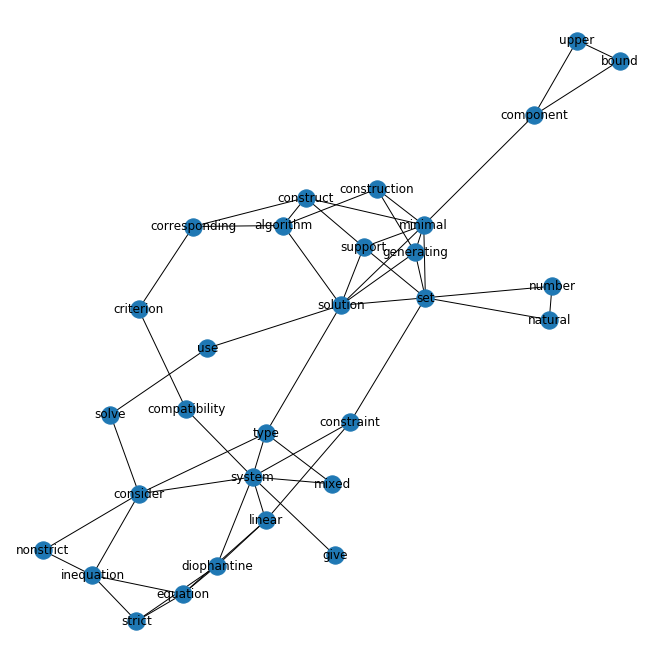

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 9))
pos = nx.spring_layout(lemma_graph)

nx.draw(lemma_graph, pos=pos, with_labels=False, font_weight="bold")
nx.draw_networkx_labels(lemma_graph, pos, labels)

Now to run the algorithm, we use `PageRank` – which is approximately _eigenvalue centrality_ – to calculate ranks for each of the nodes in the lemma graph.

In [12]:
ranks = nx.pagerank(lemma_graph)
ranks

{0: 0.025190055141357165,
 1: 0.09709174565608479,
 2: 0.03658656272138432,
 3: 0.022947339381092696,
 4: 0.07548767636963792,
 5: 0.01884004785394172,
 6: 0.01884004785394172,
 7: 0.019767433918161055,
 8: 0.03093250736456608,
 9: 0.031636552282656216,
 10: 0.0250439175297852,
 11: 0.03969617593153302,
 12: 0.02513276636673567,
 13: 0.0390375393827704,
 14: 0.02428614673389346,
 15: 0.02428614673389346,
 16: 0.031629446298645975,
 17: 0.06334806476862227,
 18: 0.061826419749828485,
 19: 0.03201021345587308,
 20: 0.02404712231242087,
 21: 0.029468555366439973,
 22: 0.04816979699201436,
 23: 0.010894627731045426,
 24: 0.026930354700088012,
 25: 0.03165915652710971,
 26: 0.029382686223731833,
 27: 0.019263849959229938,
 28: 0.01982332786706688,
 29: 0.016743716826448173}

In [13]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    print(node_id, rank, labels[node_id])

1 0.09709174565608479 system
4 0.07548767636963792 set
17 0.06334806476862227 minimal
18 0.061826419749828485 solution
22 0.04816979699201436 type
11 0.03969617593153302 inequation
13 0.0390375393827704 consider
2 0.03658656272138432 linear
19 0.03201021345587308 algorithm
25 0.03165915652710971 construct
9 0.031636552282656216 equation
16 0.031629446298645975 component
8 0.03093250736456608 diophantine
21 0.029468555366439973 generating
26 0.029382686223731833 support
24 0.026930354700088012 corresponding
0 0.025190055141357165 compatibility
12 0.02513276636673567 nonstrict
10 0.0250439175297852 strict
14 0.02428614673389346 upper
15 0.02428614673389346 bound
20 0.02404712231242087 construction
3 0.022947339381092696 constraint
28 0.01982332786706688 solve
7 0.019767433918161055 criterion
27 0.019263849959229938 use
5 0.01884004785394172 natural
6 0.01884004785394172 number
29 0.016743716826448173 mixed
23 0.010894627731045426 give


Define a function to collect the top-ranked phrases from the lemma graph.

In [14]:
import math

def collect_phrases (chunk, phrases, counts):
    chunk_len = chunk.end - chunk.start + 1
    sq_sum_rank = 0.0
    non_lemma = 0
    compound_key = set([])

    for i in range(chunk.start, chunk.end):
        token = doc[i]
        key = (token.lemma_, token.pos_)
        
        if key in seen_lemma:
            node_id = list(seen_lemma.keys()).index(key)
            rank = ranks[node_id]
            sq_sum_rank += rank
            compound_key.add(key)
        
            if logger:
                logger.debug(" {} {} {} {}".format(token.lemma_, token.pos_, node_id, rank))
        else:
            non_lemma += 1
    
    # although the noun chunking is greedy, we discount the ranks using a
    # point estimate based on the number of non-lemma tokens within a phrase
    non_lemma_discount = chunk_len / (chunk_len + (2.0 * non_lemma) + 1.0)

    # use root mean square (RMS) to normalize the contributions of all the tokens
    phrase_rank = math.sqrt(sq_sum_rank / (chunk_len + non_lemma))
    phrase_rank *= non_lemma_discount

    # remove spurious punctuation
    phrase = chunk.text.lower().replace("'", "")

    # create a unique key for the the phrase based on its lemma components
    compound_key = tuple(sorted(list(compound_key)))
    
    if not compound_key in phrases:
        phrases[compound_key] = set([ (phrase, phrase_rank) ])
        counts[compound_key] = 1
    else:
        phrases[compound_key].add( (phrase, phrase_rank) )
        counts[compound_key] += 1

    if logger:
        logger.debug("{} {} {} {} {} {}".format(phrase_rank, chunk.text, chunk.start, chunk.end, chunk_len, counts[compound_key]))

Collect the top-ranked phrases based on both the noun chunks and the named entities...

In [15]:
phrases = {}
counts = {}

for chunk in doc.noun_chunks:
    collect_phrases(chunk, phrases, counts)

for ent in doc.ents:
    collect_phrases(ent, phrases, counts)

DEBUG:PyTR: compatibility NOUN 0 0.025190055141357165
DEBUG:PyTR:0.07481838030465979 Compatibility 0 1 2 1
DEBUG:PyTR: system NOUN 1 0.09709174565608479
DEBUG:PyTR:0.14688751982088183 systems 2 3 2 1
DEBUG:PyTR: linear ADJ 2 0.03658656272138432
DEBUG:PyTR: constraint NOUN 3 0.022947339381092696
DEBUG:PyTR:0.10565323773654285 linear constraints 4 6 3 1
DEBUG:PyTR: set NOUN 4 0.07548767636963792
DEBUG:PyTR:0.06868755180600318 the set 7 9 3 1
DEBUG:PyTR: natural ADJ 5 0.01884004785394172
DEBUG:PyTR: number NOUN 6 0.01884004785394172
DEBUG:PyTR:0.08405366110543994 natural numbers 10 12 3 1
DEBUG:PyTR: criterion NOUN 7 0.019767433918161055
DEBUG:PyTR:0.06627792311867262 Criteria 13 14 2 1
DEBUG:PyTR: compatibility NOUN 0 0.025190055141357165
DEBUG:PyTR:0.07481838030465979 compatibility 15 16 2 2
DEBUG:PyTR: system NOUN 1 0.09709174565608479
DEBUG:PyTR:0.07789887100276421 a system 17 19 3 2
DEBUG:PyTR: linear ADJ 2 0.03658656272138432
DEBUG:PyTR: Diophantine PROPN 8 0.03093250736456608
DEBUG

Since noun chunks can be expressed in different ways (e.g., they may have articles or prepositions), we need to find a minimum span for each phrase based on combinations of lemmas...

In [16]:
import operator

min_phrases = {}

for compound_key, rank_tuples in phrases.items():
    l = list(rank_tuples)
    l.sort(key=operator.itemgetter(1), reverse=True)
    
    phrase, rank = l[0]
    count = counts[compound_key]
    
    min_phrases[phrase] = (rank, count)

Yield the results of TextRank...

In [17]:
for phrase, (rank, count) in sorted(min_phrases.items(), key=lambda x: x[1][0], reverse=True):
    print(phrase, count, rank)

minimal generating sets 1 0.1640996265710316
systems 4 0.14688751982088183
linear diophantine equations 1 0.1259559430077718
solutions 3 0.1172143523159633
mixed types 1 0.1103235416443912
nonstrict inequations 1 0.11025165160180313
strict inequations 1 0.11017607509798653
linear constraints 1 0.10565323773654285
a minimal supporting set 1 0.10465046837630346
upper bounds 1 0.09543220119650414
a minimal set 1 0.0952198714085986
algorithms 1 0.0843408606072513
natural numbers 1 0.08405366110543994
components 1 0.08383773520404489
diophantine 1 0.082908929105731
all the considered types systems 1 0.08278948056400119
compatibility 2 0.07481838030465979
construction 1 0.07310133349204889
the set 1 0.06868755180600318
criteria 2 0.06627792311867262
the corresponding algorithms 1 0.06204175981712335
all types 1 0.05486904693906117


Just for kicks, compare with raw results of the non-chunked lemma nodes...

In [18]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    print(labels[node_id], rank)

system 0.09709174565608479
set 0.07548767636963792
minimal 0.06334806476862227
solution 0.061826419749828485
type 0.04816979699201436
inequation 0.03969617593153302
consider 0.0390375393827704
linear 0.03658656272138432
algorithm 0.03201021345587308
construct 0.03165915652710971
equation 0.031636552282656216
component 0.031629446298645975
diophantine 0.03093250736456608
generating 0.029468555366439973
support 0.029382686223731833
corresponding 0.026930354700088012
compatibility 0.025190055141357165
nonstrict 0.02513276636673567
strict 0.0250439175297852
upper 0.02428614673389346
bound 0.02428614673389346
construction 0.02404712231242087
constraint 0.022947339381092696
solve 0.01982332786706688
criterion 0.019767433918161055
use 0.019263849959229938
natural 0.01884004785394172
number 0.01884004785394172
mixed 0.016743716826448173
give 0.010894627731045426
